In [1]:

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
from matplotlib.patches import Polygon
import pandas as pd


Using MPI version 3.1, 1 processes


ModuleNotFoundError: No module named 'torch'

In [10]:


from datetime import datetime

now=datetime.now()
thetime=str(now.day)+str(now.hour)+str(now.minute)
abspath='/mnt/d/Dai(COMSOL2)/meepmedia/plots/'

In [11]:
a = 1
r=0.24
n=12
theta=0
Bar = 8 # the barrier PhC to confine light
Ls=[20,20]# a list of the length of bent wg segments
parity=np.power(-1,len(Ls))
output_index=int((parity+1)/2) #the final waveguide may direct downwards or rightwards
Ls_temp=Ls.copy()

Pso=5
Wso=5
Pin=10
Pout=5
Wport=10

extra_N=np.abs(Pso)+3 # add some extra length and then delete it, so as to smooth the edge
Ls_temp[0]+=extra_N
Ls_temp[-1]+=extra_N


In [12]:


def data(Lst):  # split the x and y data stored in a nested list, thus ready for pyplot line plotting
    k = 0
    xxx = []
    yyy = []

    while k < len(Lst):
        xxx.append(Lst[k][0])
        yyy.append(Lst[k][1])

        k = k + 1
    return xxx, yyy


def distance(v1, v2):  # distance between two 2d points
    d = np.sqrt((v1[0] - v2[0]) ** 2 + (v1[1] - v2[1]) ** 2)
    return d

def moveframe(original_frame, vector):
    new_frame = []
    for var in original_frame:
        new_frame.append([var[0] + vector[0], var[1] + vector[1]])
    return new_frame

def frameX(N0, M0):
    frame = []
    for i, j in np.ndindex((N0, M0)):
        frame.append([a * i, a * j])
    return frame

def frameM(N0, M0):  # the frame
    frame = []
    for i, j in np.ndindex((N0, M0)):
        frame.append([a*np.sqrt(2) * (i+0.25)-N0*np.sqrt(2)*a/2, a*np.sqrt(2) * (j+0.25)-M0*np.sqrt(2)*a/2])
        frame.append([a*np.sqrt(2) * (i+0.75)-N0*np.sqrt(2)*a/2, a*np.sqrt(2) * (j+0.75)-M0*np.sqrt(2)*a/2])

    return frame


def polygons(r0, n0, theta0):
    polygon = []
    for i in range(n0):
        polygon.append(
            [r0 * np.sin(2 * np.pi / n0 * i + theta0 / 180 * np.pi),
             r0 * np.cos(2 * np.pi / n0 * i + theta0 / 180 * np.pi)])
    return polygon


def patterning(Frame, Polygon):  # polygons have default center (0,0). create polygon arrays on the frame.
    bulk = []
    for i in range(len(Frame)):
        on_center = Frame[i]
        New_poly = []
        for j in range(len(Polygon)):
            vertice = [sum(x) for x in zip(on_center, Polygon[j])]
            New_poly.append(vertice)
            
        bulk.append(New_poly)
    return bulk

def meepvector(point):
    result=mp.Vector3(point[0],point[1])

    return result

def meepshape(shape):
    meep_shape=[]
    for vertice in shape:
        meep_shape.append(meepvector(vertice))

    return meep_shape

def meepprism(shape,material):
    result=mp.Prism(vertices=meepshape(shape),height=mp.inf,material=material)

    return result

def meepbulk(bulk,material):
    geo=[]
    for shape in bulk:
        geo.append(meepprism(shape,material))

    return  geo


def parameter_generator(List_seg):
    global parity
    Neven = sum(List_seg[::2])
    Nodd = sum(List_seg[1::2])
    Mb=int(Nodd+Bar+(1-parity)/2*Bar)
    Nb=int(Neven+(parity+1)/2*Bar)
    Ns = sum(List_seg)
    Ms = Bar * 2
    spine_s = [[-Ns*np.sqrt(2)*a/2, 0], [Ns * a*np.sqrt(2)/2, 0]]
    spine_b = [[-Nb*np.sqrt(2)*a/2, (Mb/2-Bar) * a*np.sqrt(2)]]
    for i in range(len(List_seg)):
        parity1 = np.power(-1, i)
        new_point = spine_b[-1][:]
        new_point[int((1 - parity1) / 2)] += parity1 * List_seg[i]*a*np.sqrt(2)
        spine_b.append(new_point)
    List_s=[Ns, Ms, spine_s]
    List_b=[Nb, Mb, spine_b]
    package=[List_s,List_b]

    return package


def outside(obj,spine):
    value=1
    for point in spine:
        if obj[0]<point[0] and obj[1]<point[1]:
            value*=0
        else:
            value*=1
    return value==0


def cutblokcs(frame,spine):
    upper=[]
    lower=[]
    for point in frame:
        if outside(point,spine):
            lower.append(point)

        else:
            upper.append(point)
    return upper, lower


def cleanedge(frame,spine):
    new_frame=[]
    left=spine[0][0]+extra_N*a*np.sqrt(2)

    if len(spine)>2:
        right=spine[-1][int((parity+1)/2)]+parity*extra_N*a*np.sqrt(2)
        for point in frame:
            if point[0]>=left and (right-point[int((parity+1)/2)])*parity<=0:
                new_frame.append(point)

    else:
        right=spine[1][0]-extra_N*a*np.sqrt(2)
        for point in frame:
            if left<= point[0]<=right:
                new_frame.append(point)
    return new_frame



# try to plot a bent waveguide
def makebent(S):

    global Ls,Ls_temp
    polygon=polygons(r,n,theta)
    param_package=parameter_generator(Ls_temp)
    spines=[param_package[0][2],param_package[1][2]]
    bulk_package=[]
    for i in [0,1]:
        list_sb=param_package[i]
        NN,MM,sspine=list_sb
        fframe=frameM(NN,MM)
        upper, lower = cutblokcs(fframe, sspine)
        upper = moveframe(upper, (S * a / np.sqrt(2)/2, S * a / np.sqrt(2)/2))
        lower = moveframe(lower, (-S * a / np.sqrt(2)/2, -S * a / np.sqrt(2)/2))
        #print("origionallower=",lower[0:3])
        upper=cleanedge(upper,sspine)
        lower=cleanedge(lower,sspine)
        bulk_upper = patterning(upper, polygon)
        bulk_lower = patterning(lower, polygon)
        #print("lower=",lower[0:3])
        bulk_package.append([bulk_upper,bulk_lower])

    return bulk_package,param_package

In [13]:
decay="i"   # i for running till intensity decays to [check_dBm], t for fixed sim time, g for quick geometry check, a for exporting animation 
ani=bool(decay=="a")
Tvideo=300  # decay time used for making animation
n_eff = 2.7
f_input=225
check_dBm = 30
a0=500
c_const0=299792458
fcen=1000*f_input*a0/c_const0  #normalized center freq
df = 0.1
nfreq = 500 # number of frequencies at which to compute flux
dpml=1
parameterS=2


resolution = 16
eps=n_eff**2
eps2=1  # sometimes the input wire is not needed, set its eps to 1.

In [14]:

def phc_trans(wgtype=0, T_decay=1000):   #wgtype=0 for straight wg, 1 for bent wg, 0.1 for free space but skips the animation code, 0.2 for free space as well but can output mode evolution.mp4

    bulk_package,params=makebent(parameterS)
    print("all is fine here")

    def meepports():
    
        port_package=[]
        for i in [0,1]:
            spine=params[i][2]
            left=spine[0][0]+extra_N*np.sqrt(2)*a
            source=[mp.Source(mp.GaussianSource(fcen, fwidth=df),
                              component=mp.Ez,
                              center=mp.Vector3(left-Pso*np.sqrt(2),spine[0][1]),
                              size=mp.Vector3(0,Wso))]

            port1=mp.FluxRegion(center=mp.Vector3(left+Pin*np.sqrt(2),spine[0][1]),size=mp.Vector3(0,Wport))
            decay_check=mp.Vector3(spine[-1][0]+(extra_N+Pin)*np.sqrt(2)*(((1-output_index)*parity)*i+(i-1)),spine[-1][1]+i*(extra_N+Pin)*np.sqrt(2)*(output_index)*parity)
            port2=mp.FluxRegion(center=decay_check,size=mp.Vector3(Wport*output_index*i,Wport*(1-i*output_index)))

            ports_by_wg=[source,port1,port2,decay_check]
            port_package.append(ports_by_wg)  #index 0 fr str, index 1 for bent
        return port_package

    def sizes():
        return [params[0][i]*a*np.sqrt(2) for i in [0,1]],[params[1][i]*a*np.sqrt(2) for i in [0,1]]


    cell=mp.Vector3(sizes()[int(wgtype)][0],sizes()[int(wgtype)][1],0)
    if wgtype in [0.1,0.2]:
        geometry = []   
    else:
        geometry=meepbulk(sum(bulk_package[int(wgtype)],[]),mp.Medium(epsilon=eps))

        #print(sum(bulk_package[int(wgtype)],[]))
    #waveguide = mp.Block(mp.Vector3(mp.inf,ww,mp.inf),center=mp.Vector3(0,0,0),material=mp.Medium(epsilon=eps))
    
    
    pml_layers = [mp.PML(dpml)]

    source,port1,port2,decay_check=meepports()[int(wgtype)]
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=source,
                        resolution=resolution)

    fluxes=[sim.add_flux(fcen, df, nfreq, port) for port in [port1,port2]]

    if ani and wgtype in [0,1,0.2]:
        f = plt.figure(dpi=150)
        Animate = mp.Animate2D(sim, fields=mp.Ez, f=f,
                               #field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'none'},
                               realtime=False, normalize=True)

        sim.run(mp.at_every(0.25,Animate),until=Tvideo)

        plt.close()

        filename1 = thetime+"_S="+str(parameterS)+"_wg="+str(wgtype)+'_freq='+str(f_input)+'_T='+str(Tvideo)
        filename2 = '/mnt/d/Dai(COMSOL2)/meepmedia/video2/'+filename1
        filename = filename2+".mp4"
        fps = 60
        Animate.to_mp4(fps,filename)
        Video(filename)
    else:

        # show geometry
        %matplotlib inline
        f = plt.figure(dpi=150)
        sim.plot2D(ax=f.gca())

        filename=abspath+thetime+"wg="+str(wgtype)
        if decay in ["i","t"]:
            plt.savefig(filename+".jpg")
        plt.show()
        
        if decay=="i":
            sim.run(until_after_sources=mp.stop_when_fields_decayed(100, mp.Ez, decay_check, pow(10,-check_dBm/10)))
            #plt.savefig(filename+".jpg")
        elif decay=="t":
            sim.run(until=T_decay)
            #plt.savefig(filename+".jpg")
        elif decay=="g":
            sim.run(until=1)

    results = [mp.get_flux_freqs(fluxes[-1])]
    for var in fluxes:
        results.append(mp.get_fluxes(var))

    return results


all is fine here
-----------
Initializing structure...
time for choose_chunkdivision = 0.000332832 s
Working in 2D dimensions.
Computational cell is 79.1875 x 22.625 x 0 with resolution 16
time for set_epsilon = 0.596694 s
-----------


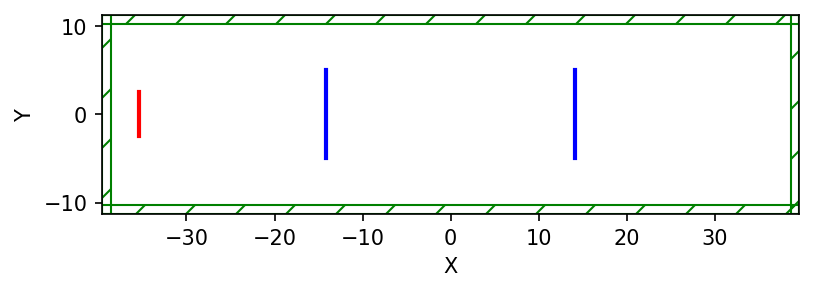

on time step 974 (time=30.4375), 0.00410977 s/step
on time step 1967 (time=61.4688), 0.00403175 s/step
on time step 3040 (time=95), 0.00373007 s/step
field decay(t = 100.03125): 0.046924213277258174 / 0.046924213277258174 = 1.0
on time step 4158 (time=129.938), 0.00357883 s/step
on time step 5257 (time=164.281), 0.00364158 s/step
on time step 6369 (time=199.031), 0.00359881 s/step
field decay(t = 200.0625): 0.04665047962417765 / 0.046924213277258174 = 0.9941664732562882
on time step 7661 (time=239.406), 0.0030962 s/step
on time step 9108 (time=284.625), 0.00276503 s/step
field decay(t = 300.09375): 1.7563181626905705e-14 / 0.046924213277258174 = 3.742882490779596e-13
run 0 finished at t = 300.09375 (9603 timesteps)


In [15]:
result_none=phc_trans(wgtype=0.2)  # only ports and free space

all is fine here
-----------
Initializing structure...
time for choose_chunkdivision = 0.941469 s
Working in 2D dimensions.
Computational cell is 79.1875 x 22.625 x 0 with resolution 16
     prism, center = (-27.9307,1.76777,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 12 vertices:
          (-27.9307,2.00777,0)
          (-27.8107,1.97561,0)
          (-27.7229,1.88777,0)
          (-27.6907,1.76777,0)
          (-27.7229,1.64777,0)
          (-27.8107,1.55992,0)
          (-27.9307,1.52777,0)
          (-28.0507,1.55992,0)
          (-28.1386,1.64777,0)
          (-28.1707,1.76777,0)
          (-28.1386,1.88777,0)
          (-28.0507,1.97561,0)
          dielectric constant epsilon diagonal = (7.29,7.29,7.29)
     prism, center = (-27.9307,3.18198,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 12 vertices:
          (-27.9307,3.42198,0)
          (-27.8107,3.38983,0)
          (-27.7229,3.30198,0)
          (-27.6907,3.18198,0)
    

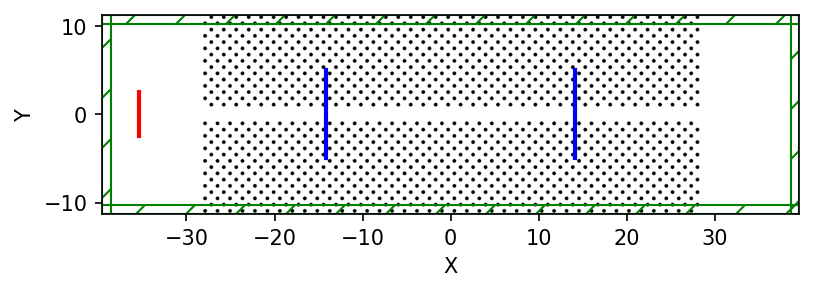

on time step 1134 (time=35.4375), 0.00352773 s/step
on time step 2340 (time=73.125), 0.00331823 s/step
field decay(t = 100.03125): 1.302034686229804e-09 / 1.302034686229804e-09 = 1.0
on time step 3636 (time=113.625), 0.00308919 s/step
on time step 4981 (time=155.656), 0.00297508 s/step
on time step 6325 (time=197.656), 0.00297783 s/step
field decay(t = 200.0625): 0.30312558320894106 / 0.30312558320894106 = 1.0
on time step 7642 (time=238.812), 0.00303875 s/step
on time step 8981 (time=280.656), 0.0029878 s/step
field decay(t = 300.09375): 0.027788141055879366 / 0.30312558320894106 = 0.09167204154037144
on time step 10265 (time=320.781), 0.0031175 s/step
on time step 11551 (time=360.969), 0.00311101 s/step
field decay(t = 400.125): 0.0010771383878870147 / 0.30312558320894106 = 0.0035534393913052046
on time step 12849 (time=401.531), 0.00308284 s/step
on time step 14172 (time=442.875), 0.003025 s/step
on time step 15498 (time=484.312), 0.0030168 s/step
field decay(t = 500.15625): 0.00038

In [16]:
result_str=phc_trans(wgtype=0,T_decay=2000)

all is fine here
-----------
Initializing structure...
time for choose_chunkdivision = 1.07117 s
Working in 2D dimensions.
Computational cell is 50.9375 x 50.9375 x 0 with resolution 16
     prism, center = (-13.7886,15.9099,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 12 vertices:
          (-13.7886,16.1499,0)
          (-13.6686,16.1177,0)
          (-13.5807,16.0299,0)
          (-13.5486,15.9099,0)
          (-13.5807,15.7899,0)
          (-13.6686,15.7021,0)
          (-13.7886,15.6699,0)
          (-13.9086,15.7021,0)
          (-13.9964,15.7899,0)
          (-14.0286,15.9099,0)
          (-13.9964,16.0299,0)
          (-13.9086,16.1177,0)
          dielectric constant epsilon diagonal = (7.29,7.29,7.29)
     prism, center = (-13.7886,17.3241,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 12 vertices:
          (-13.7886,17.5641,0)
          (-13.6686,17.532,0)
          (-13.5807,17.4441,0)
          (-13.5486,17.3241,0)
     

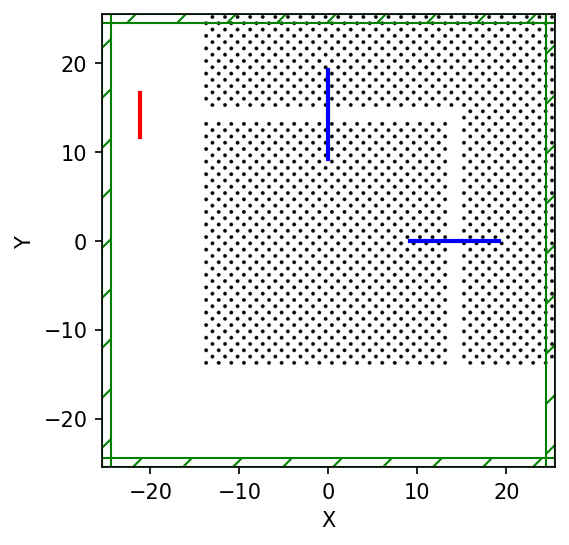

on time step 827 (time=25.8438), 0.00484174 s/step
on time step 1665 (time=52.0312), 0.0047739 s/step
on time step 2534 (time=79.1875), 0.00460521 s/step
field decay(t = 100.03125): 1.725306974030645e-08 / 1.725306974030645e-08 = 1.0
on time step 3369 (time=105.281), 0.00479172 s/step
on time step 4230 (time=132.188), 0.00465001 s/step
on time step 5052 (time=157.875), 0.00486645 s/step
on time step 5792 (time=181), 0.00541054 s/step
field decay(t = 200.0625): 0.2537573448063662 / 0.2537573448063662 = 1.0
on time step 6487 (time=202.719), 0.00575736 s/step
on time step 7171 (time=224.094), 0.00585473 s/step
on time step 7850 (time=245.312), 0.00589586 s/step
on time step 8532 (time=266.625), 0.00586718 s/step
on time step 9255 (time=289.219), 0.00553302 s/step
field decay(t = 300.09375): 0.024216252930513306 / 0.2537573448063662 = 0.09543074683805478
on time step 9940 (time=310.625), 0.00584274 s/step
on time step 10605 (time=331.406), 0.00601507 s/step
on time step 11364 (time=355.125

In [17]:
result_bent=phc_trans(wgtype=1,T_decay=3000)

In [18]:

def sortports(result):
    result_array=np.array(result)
    f,p1,p2=result_array
    return f,p1,p2

abspath='/mnt/d/Dai(COMSOL2)/meepmedia/plots/'

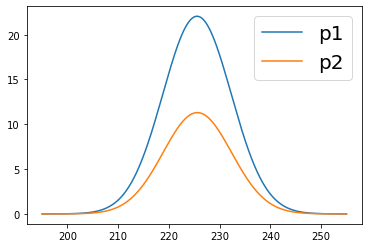

In [19]:

try:
    fig, ax = plt.subplots()
    f,p1_none,p2_none=sortports(result_none)
    freqs=c_const0 * np.array(f)/a0/1000
    ax.plot(freqs,p1_none,label="p1")
    ax.plot(freqs,p2_none,label="p2")
    plt.legend(fontsize=20)
    if decay in ["t","i"]:    
        plt.savefig(abspath+thetime+"none.png")
    #plt.ylim([0,1.2])
except Exception as e: print(e)

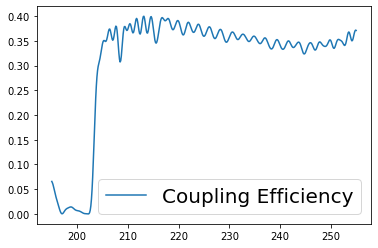

In [20]:

try:
    fig, ax = plt.subplots()
    f,p1_str,p2_str=sortports(result_str)
    couplingE=p1_str/p1_none
    freqs=c_const0 * np.array(f)/a0/1000
    ax.plot(freqs,couplingE,label="Coupling Efficiency")
    #ax.plot(freqs,p2_str,label="p2")
    plt.legend(fontsize=20)
    if decay in ["t","i"]:    
        plt.savefig(abspath+thetime+"CE.png")
    #plt.ylim([0,1.2])
except Exception as e: print(e)

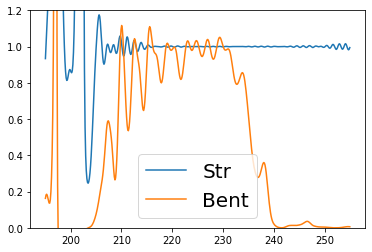

In [21]:

try:
    fig, ax = plt.subplots()
    f,p1_bent,p2_bent=sortports(result_bent)
    if parity==1:
        p2_bent=[element*-1 for element in p2_bent]

    T_str=p2_str/p1_str
    T_bent=p2_bent/p1_str
    freqs=c_const0 * np.array(f)/a0/1000
    ax.plot(freqs,T_str,label="Str")
    ax.plot(freqs,T_bent,label="Bent")
    plt.legend(fontsize=20)
    plt.ylim([0,1.2])
    if decay in ["t","i"]:    
        plt.savefig(abspath+thetime+"_S="+str(parameterS)+"_T-spectra.png")

except Exception as e: print(e)

In [22]:
if decay in ["i","t"]:
    dff = pd.DataFrame()
    dff["freq"] = freqs
    dff["Coupling Efficiency"] = couplingE
    dff["Str"] = T_str
    dff["Bent"]=T_bent
    dff.to_csv(abspath+thetime+"S="+str(parameterS)+".csv", index=False)